In [ ]:
import numpy as np
import cv2 as cv
import math
from PIL import Image

import matplotlib.pyplot as plt


In [ ]:

def hough_peaks(H, peaks, neighborhood_size=3):
    """Calculate the indices of the peaks.
    Args:
        H: the accumulator
        peaks: number of line peaks.
        neighborhood_size (int, optional): the size of the region to detect 1 line within. Defaults to 3.
    Returns:
        indices (np.ndarray): the indices of the peaks.
        H: accumulator that holds only the line points.
    """
    
    indices = []
    H1 = np.copy(H)
    
    # loop through number of peaks to identify
    for i in range(peaks):
        idx = np.argmax(H1)  # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape)  # remap to shape of H to be 2d array
        indices.append(H1_idx)

        idx_y, idx_x = H1_idx  # separate x, y indices from argmax(H)
        
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (neighborhood_size / 2)) < 0:
            min_x = 0
        else:
            min_x = idx_x - (neighborhood_size / 2)
        if (idx_x + (neighborhood_size / 2) + 1) > H.shape[1]:
            max_x = H.shape[1]
        else:
            max_x = idx_x + (neighborhood_size / 2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (neighborhood_size / 2)) < 0:
            min_y = 0
        else:
            min_y = idx_y - (neighborhood_size / 2)
        if (idx_y + (neighborhood_size / 2) + 1) > H.shape[0]:
            max_y = H.shape[0]
        else:
            max_y = idx_y + (neighborhood_size / 2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(int(min_x), int(max_x)):
            for y in range(int(min_y), int(max_y)):
                
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if x == min_x or x == (max_x - 1):
                    H[y, x] = 255
                if y == min_y or y == (max_y - 1):
                    H[y, x] = 255

    # return the indices and the original Hough space with selected points
    return indices, H

In [ ]:

def hough_lines_draw(img, indices, rhos, thetas):
    """Draw lines according to specific rho and theta
    Args:
        img (np.ndarray): image to draw on
        indices: indices of the peaks points
        rhos: norm distances of each line from origin
        thetas: the angles between the norms and the horizontal x axis
    """ 

    for i in range(len(indices)):
        # get lines from rhos and thetas
        rho = rhos[indices[i][0]]
        theta = thetas[indices[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        # these are then scaled so that the lines go off the edges of the image
        y1 = int(y0 + 1000 * (a))
        x1 = int(x0 + 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        
        cv.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

In [ ]:


def line_detection(image: np.ndarray):
    """Fucntion that detects lines in hough domain
    Args:
        image (np.ndarray())
    Returns:
        accumulator: hough domain curves
        rhos: norm distances of each line from origin
        thetas: the angles between the norms and the horizontal x axis
    """
    grayImg = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurImg = cv.GaussianBlur(grayImg, (5,5), 1.5)
    edgeImg = cv.Canny(blurImg, 100, 200)
    

    height, width = edgeImg.shape
    
    maxDist = int(np.around(np.sqrt(height**2 + width**2)))
    
    thetas = np.deg2rad(np.arange(-90, 90))
    rhos = np.linspace(-maxDist, maxDist, 2*maxDist)
    
    accumulator = np.zeros((2 * maxDist, len(thetas)))
    
    for y in range(height):
        for x in range(width):
            if edgeImg[y,x] > 0:
                for k in range(len(thetas)):
                    r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])
                    accumulator[int(r) + maxDist, k] += 1
                    
    return accumulator, thetas, rhos


def hough_lines(source: np.ndarray, peaks: int = 10):
    """detect lines and draw them on the image
    Args:
        source (np.ndarray): image
        peaks (int, optional): number of line peaks. Defaults to 10.
    Returns:
        image: image with detected lines
    """
    
    src = np.copy(source)
    H, thetas, rhos = line_detection(src)
    indicies, H = hough_peaks(H, peaks, neighborhood_size=10) 
    hough_lines_draw(src, indicies, rhos, thetas)

    return src

(-0.5, 509.5, 339.5, -0.5)

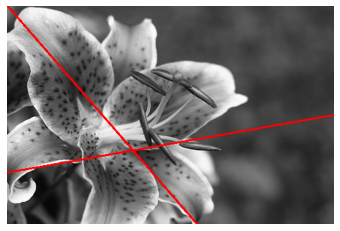

In [ ]:
image = Image.open('/content/original1.jpeg')

finalImg = hough_lines(image, 2)

# finalImgVSRealImg = np.concatenate((image, finalImg), axis=1)
plt.imshow(finalImg)
plt.axis("off")